In [1]:
#Importing all the libraries necessary for this project

import pandas as pd
import numpy as np
import zipfile
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, precision_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import neighbors
from sklearn.svm import SVC 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats


The dimension of VS1 is :  (2205, 60)
The dimension of TS1 is :  (2205, 60)
The dimension of SE is :  (2205, 60)


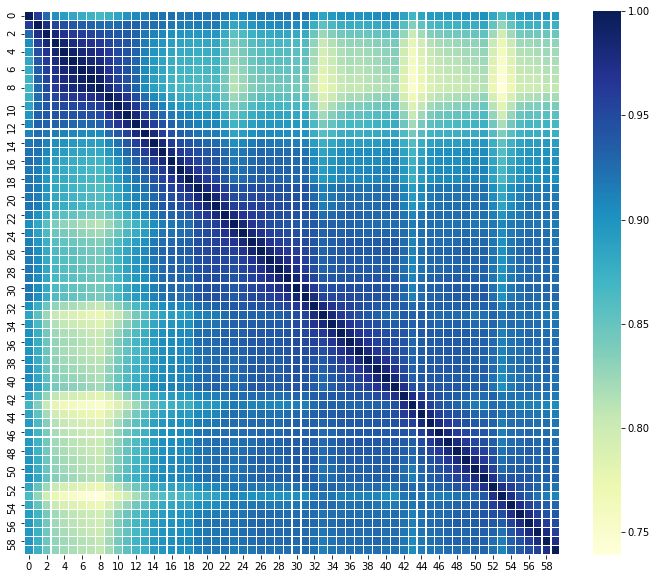

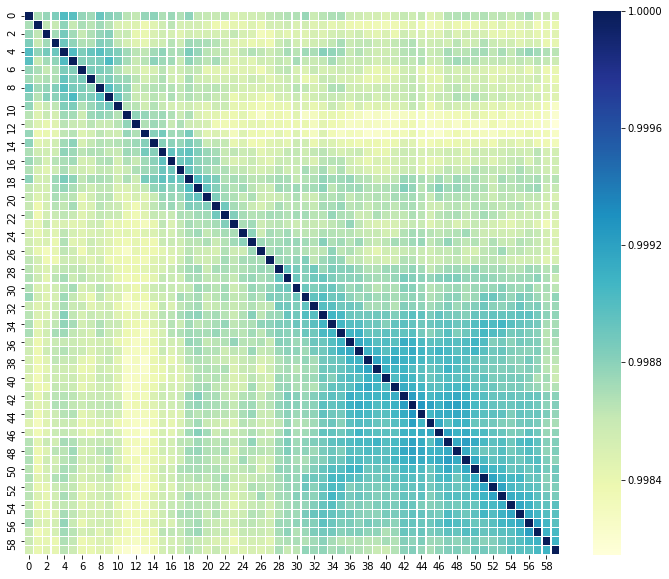

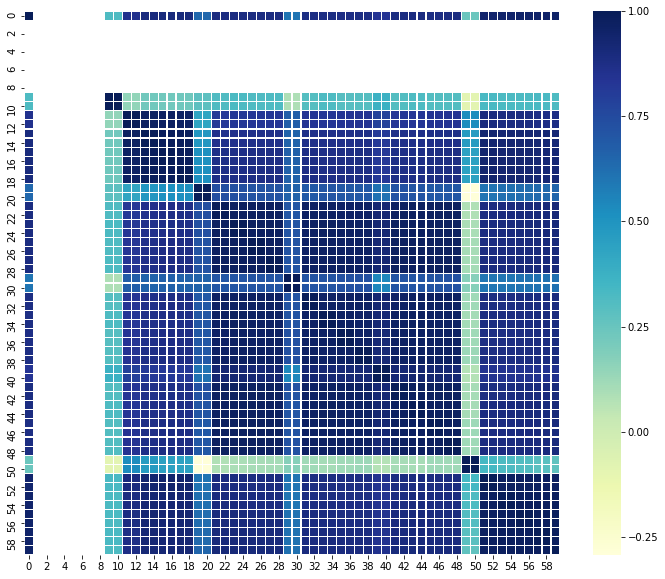

In [2]:
# This is such a big data set. 
# I want to check it attribution in a given sensor is highly correlated
# I picked VS1 and TS1 to compute the correlation table
# Spearman rank correlation for all the features in VS shown by heatmap
# It seems like most of the features in a sensor are highly correlated
VS1 = pd.read_table('VS1.txt', header=None)
TS1 = pd.read_table('TS1.txt', header=None)
SE = pd.read_table('SE.txt', header=None)


print("The dimension of VS1 is : ", VS1.shape)    
corrmat1 = VS1.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat1, ax=ax, cmap="YlGnBu", linewidths=0.1)


print("The dimension of TS1 is : ", TS1.shape)    
corrmat2 = TS1.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat2, ax=ax, cmap="YlGnBu", linewidths=0.1)

print("The dimension of SE is : ", SE.shape)    
corrmat3 = SE.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat3, ax=ax, cmap="YlGnBu", linewidths=0.1)




In [3]:
# Load all attribute data from txts
test_list = ['VS1', 'TS1', 'TS2', 'TS3', 'TS4','SE', 'PS1',
             'PS2', 'PS3', 'PS4', 'PS5',
              'PS6', 'FS1', 'FS2', 'EPS1', 'CP', 'CE']

test_list = [s + '.txt' for s in test_list]

new_df = {}
master_df = pd.DataFrame()
for key in test_list:
    df = pd.read_table(key, header=None)
    master_df = pd.concat([master_df, df.median(axis=1)], axis=1)
# Load the target variable, only keep the internal pump leakage as target variable.
# Internal pump leakage has three levels, 0, 1, and 2.
target_df = pd.read_table('profile.txt', header=None)
target_df = target_df.drop([0,1,3,4], axis=1)



In [4]:
alldata = master_df
alldata = pd.concat([alldata, target_df], axis=1)

In [5]:
alldata.columns = ["VS1", "TS1", "TS2", "TS3", "TS4","SE", 
                   "PS1", "PS2", "PS3", "PS4", "PS5",
              "PS6", "FS1", "FS2", "EPS1", "CP", "CE", "y"]
alldata.head()

,VS1,TS1,TS2,TS3,TS4,SE,PS1,PS2,PS3,PS4,PS5,PS6,FS1,FS2,EPS1,CP,CE,y
0,0.5770,35.5720,40.9630,38.4960,31.576,68.5145,156.25,129.365,2.297,0.0,9.844,9.733,7.836,10.327,2479.8,1.9240,40.6755,0
1,0.5595,36.7675,41.5180,38.9845,34.553,68.5360,156.06,129.385,2.273,0.0,9.632,9.526,7.853,10.403,2470.0,1.2340,25.3855,0
2,0.5620,38.0235,42.4235,39.6270,35.635,68.8530,155.72,129.325,2.273,0.0,9.528,9.425,7.847,10.367,2457.4,1.1095,22.1040,0
3,0.5550,39.0550,43.3650,40.3420,36.635,69.0060,155.56,128.865,2.242,0.0,9.436,9.335,7.843,10.302,2448.0,1.0660,20.4805,0
4,0.5760,39.9670,44.3355,41.3400,37.439,69.0130,155.34,129.000,2.219,0.0,9.358,9.260,7.831,10.236,2440.6,1.0725,19.7985,0


In [6]:
# Data Quality Check
print(alldata.head())
print(alldata.dtypes)
print(alldata.shape)

      VS1      TS1      TS2      TS3     TS4       SE     PS1      PS2    PS3  \
0  0.5770  35.5720  40.9630  38.4960  31.576  68.5145  156.25  129.365  2.297   
1  0.5595  36.7675  41.5180  38.9845  34.553  68.5360  156.06  129.385  2.273   
2  0.5620  38.0235  42.4235  39.6270  35.635  68.8530  155.72  129.325  2.273   
3  0.5550  39.0550  43.3650  40.3420  36.635  69.0060  155.56  128.865  2.242   
4  0.5760  39.9670  44.3355  41.3400  37.439  69.0130  155.34  129.000  2.219   

   PS4    PS5    PS6    FS1     FS2    EPS1      CP       CE  y  
0  0.0  9.844  9.733  7.836  10.327  2479.8  1.9240  40.6755  0  
1  0.0  9.632  9.526  7.853  10.403  2470.0  1.2340  25.3855  0  
2  0.0  9.528  9.425  7.847  10.367  2457.4  1.1095  22.1040  0  
3  0.0  9.436  9.335  7.843  10.302  2448.0  1.0660  20.4805  0  
4  0.0  9.358  9.260  7.831  10.236  2440.6  1.0725  19.7985  0  
VS1     float64
TS1     float64
TS2     float64
TS3     float64
TS4     float64
SE      float64
PS1     float64
PS2  

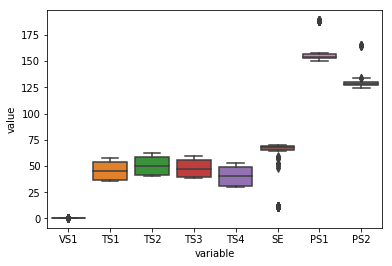

In [7]:

sns.boxplot(x="variable", y="value", data=pd.melt(
    alldata[['VS1', 'TS1', 'TS2', 'TS3', 'TS4', 'SE', 'PS1', 'PS2']]))


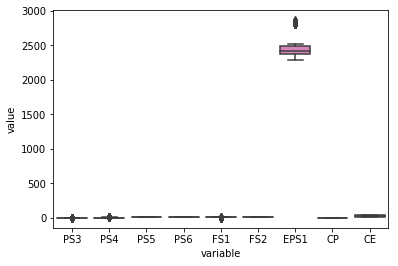

In [8]:
sns.boxplot(x="variable", y="value", data=pd.melt(
    alldata[['PS3', 'PS4', 'PS5','PS6', 'FS1', 'FS2', 'EPS1', 'CP', 'CE']]))


In [9]:
# It looks like four variables might contain outlier: SE, PS1, PS2, and EPS1.
# Detect the outlier using Z-score 

z = np.abs(stats.zscore(alldata))
threshold = 3

# Remove the outliers and get the clean data
# store orignial in alldataorg

alldataorg = alldata

alldata = alldata[(z < threshold).all(axis=1)]
print(alldataorg.shape, alldata.shape)

# removed 2205 - 2185 = 20 rows from the dataset i.e. outliers have been removed.

(2205, 18) (2185, 18)


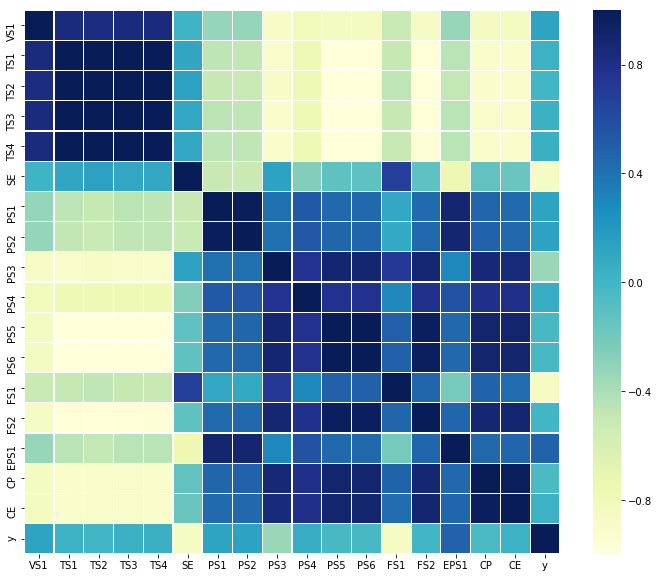

In [10]:
#correlation matrix of median matrix
corrmat = alldata.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1)

In [11]:
y = alldata[['y']].values.ravel()
x = alldata[['VS1', 'TS1', 'TS2', 'TS3', 'TS4','SE',
             'PS1', 'PS2', 'PS3', 'PS4', 'PS5',
              'PS6', 'FS1', 'FS2', 'EPS1', 'CP', 'CE']]
# Splitting up data into 70% train data and 30% test data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42)
print(x_train.head())
print(x_test.head())

        VS1     TS1      TS2     TS3      TS4       SE     PS1      PS2  \
379  0.7635  56.586  59.7695  58.203  51.9730  11.1750  188.34  132.320   
944  0.6100  46.172  51.0860  48.281  41.7660  65.4920  152.94  127.025   
444  0.6170  56.371  60.8455  57.781  51.2265  69.1905  151.12  125.085   
273  0.6440  54.486  58.9160  55.848  49.6130  66.8530  151.34  125.700   
245  0.6550  54.377  58.8340  55.824  49.6090  65.2445  151.09  125.450   

       PS3  PS4    PS5    PS6    FS1    FS2    EPS1      CP       CE  
379  0.859  0.0  8.437  8.389  1.155  8.987  2843.8  1.5045  19.1085  
944  1.969  0.0  9.021  8.945  7.421  9.627  2404.4  1.6925  26.6075  
444  2.000  0.0  8.467  8.415  7.701  9.025  2320.0  1.5770  20.4980  
273  1.937  0.0  8.523  8.466  7.465  9.196  2337.4  1.5420  20.1120  
245  1.883  0.0  8.526  8.469  7.345  9.198  2345.6  1.5355  20.1135  
         VS1      TS1      TS2      TS3      TS4       SE     PS1      PS2  \
284   0.6465  54.4920  58.9765  55.8630  49.6

(17, 17)


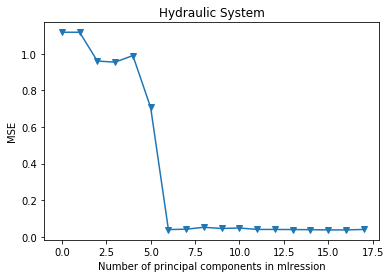

In [13]:
# Perform principal component regression (PCR) on the data
# Combine principal component analysis with multinomial logistic regression
# 10-folder cross-validation applied 
# to get the best number of components with the lowest MSE

pca = PCA()
X_reduced_train = pca.fit_transform(scale(x_train))
n = len(X_reduced_train)
print(pca.components_.shape)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)
mse = []
mlr = LogisticRegression(solver='lbfgs', multi_class='multinomial')

# Calculate MSE with only the intercept 
# (no principal components in mlression)
score = -1*cross_val_score(mlr, np.ones((n,1)),
                           y_train, cv=kf_10, 
                           scoring='neg_mean_squared_error').mean()    
mse.append(score)
# Calculate MSE using CV for the 17 principle components, 
# adding one component at the time.
for i in np.arange(1, 18):
    score = -1*cross_val_score(mlr, X_reduced_train[:,:i],
                               y_train, cv=kf_10, 
                               scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in mlression')
plt.ylabel('MSE')
plt.title('Hydraulic System')
plt.xlim(xmin=-1);
# The below plot indicates that the training MSE is 
# one of the lowest when doing regression on 6 components.


In [14]:
# Transform test data with PCA loadings 
# Fit Multinomial Logistic Regression on 6 principal components


X_reduced_test = pca.transform(scale(x_test))[:,:7]

mlr.fit(X_reduced_train[:,:7], y_train)

# MLR applied to the test data
predictions_MLR = mlr.predict(X_reduced_test)
print(mean_squared_error(y_test, predictions_MLR))

0.039634146341463415


Accuracy Score is:
0.9603658536585366

Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       365
          1       0.93      0.90      0.91       151
          2       0.91      0.94      0.93       140

avg / total       0.96      0.96      0.96       656



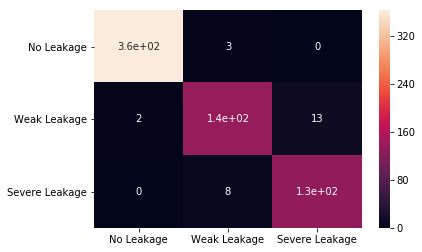

In [15]:
# Print Accuracy Score for MLR
print("Accuracy Score is:")
print(accuracy_score(y_test, predictions_MLR))
print()
# Classification Report of Prediction
print("Classification Report:")
print(classification_report(y_test, predictions_MLR))
# Confusion Matrix for predictions made
conf2 = confusion_matrix(y_test,predictions_MLR)
conf2
# Plot Confusion Matrix
label = ["No Leakage","Weak Leakage","Severe Leakage"]
sns.heatmap(conf2, annot=True, 
            xticklabels=label, yticklabels=label)

Accuracy Score is:
0.9939024390243902

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       365
          1       0.98      0.99      0.99       151
          2       0.99      0.99      0.99       140

avg / total       0.99      0.99      0.99       656



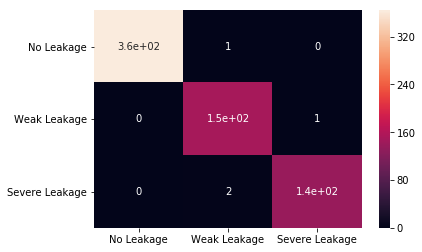

In [16]:
# Train linear discriminant analysis
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

# LDA applied to train data
predictions_lda = lda.predict(x_test)
# Print Accuracy Score for LDA
print("Accuracy Score is:")
print(accuracy_score(y_test, predictions_lda))
print()
# Classification Report of Prediction
print("Classification Report:")
print(classification_report(y_test, predictions_lda))
# Confusion Matrix for predictions made
conf2 = confusion_matrix(y_test,predictions_lda)
conf2
# Plot Confusion Matrix
label = ["No Leakage","Weak Leakage","Severe Leakage"]
sns.heatmap(conf2, annot=True, 
            xticklabels=label, yticklabels=label)

In [17]:
# Find the best parameter combination for Random Forest
fit_rf = RandomForestClassifier(random_state=42)
np.random.seed(42)

param_dist = {'max_depth': [2, 3, 4],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(fit_rf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n', 
      cv_rf.best_params_)


Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto'}


Accuracy Score is: 
0.9832317073170732

Classification Report: 
             precision    recall  f1-score   support

          0       1.00      0.99      1.00       365
          1       0.93      1.00      0.96       151
          2       1.00      0.94      0.97       140

avg / total       0.98      0.98      0.98       656



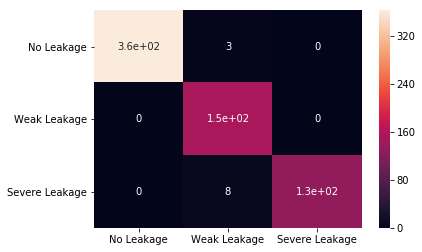

In [18]:
# Random Forest Classification Algorithm applied to train data
RF = RandomForestClassifier(criterion = 'gini',
                  max_features = 'auto', 
                  max_depth = 4)
RF.fit(x_train, y_train)
RF.score(x_train, y_train)
# Predict Random Forest Algorithm on Test Data
predictions_RF = RF.predict(x_test)
# Print Accuracy Score for Random Forest Algorithm
print("Accuracy Score is: ")
print(accuracy_score(y_test, predictions_RF))
print()
# Classification Report of Prediction
print("Classification Report: ")
print(classification_report(y_test, predictions_RF))
# Confusion Matrix for predictions made
conf = confusion_matrix(y_test, predictions_RF)
conf
# Plot Confusion Matrix
label = ["No Leakage","Weak Leakage","Severe Leakage"]
sns.heatmap(conf, annot = True, 
            xticklabels = label, yticklabels = label)
plt.show()

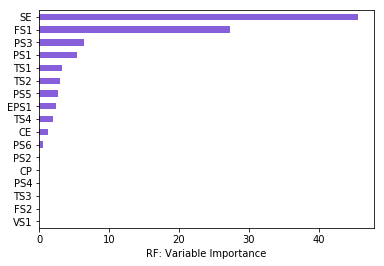

In [19]:
Importance = pd.DataFrame({'Importance':RF.feature_importances_*100},
                          index = x.columns)
Importance.sort_values(
    'Importance', axis=0, ascending=True).plot(kind='barh', color='#875FDB')
plt.xlabel('RF: Variable Importance')
plt.gca().legend_ = None

In [20]:
# Need to train a Support Vector Machine classifier
# find the parameters by cross-validation
# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100],
                     'gamma': [0.5, 1,2,3,4]}]
clf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, 
                   cv=10, scoring='accuracy', return_train_score=True)
clf.fit(x_train, y_train)
#clf.cv_results_

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.5, 1, 2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [21]:
# The best parameter set
print(clf.best_params_)

{'C': 10, 'gamma': 0.5}


Accuracy Score is: 
0.9817073170731707

Classification Report: 
             precision    recall  f1-score   support

          0       0.97      1.00      0.99       365
          1       0.99      0.98      0.98       151
          2       1.00      0.94      0.97       140

avg / total       0.98      0.98      0.98       656



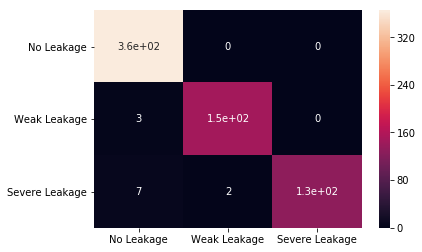

In [22]:
# Print Accuracy Score for SVM
print("Accuracy Score is: ")
print(clf.best_estimator_.score(x_test, y_test))
print()
# Classification Report of Prediction
print("Classification Report: ")
print(classification_report(y_test, clf.best_estimator_.predict(x_test)))
# Confusion Matrix for predictions made
conf = confusion_matrix(y_test, clf.best_estimator_.predict(x_test))
conf
# Plot Confusion Matrix
label = ["No Leakage","Weak Leakage","Severe Leakage"]
sns.heatmap(conf, annot = True, xticklabels = label, yticklabels = label)
plt.show()

In [23]:
# Need to train k-Nearest Neighbor
# First I would like to observe the accuracies for different values of k.
# Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(x_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(x_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(x_test, y_test) 



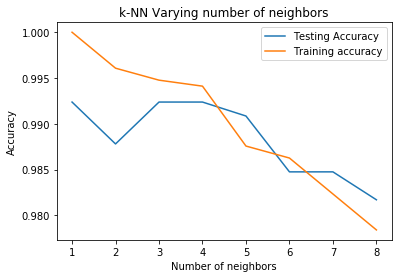

[0.99237805 0.98780488 0.99237805 0.99237805 0.99085366 0.9847561
 0.9847561  0.98170732]


In [24]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()
print(test_accuracy)
# As we can see from the plot, 
# it appears like the test accuracy is highest when using 1, 3, and 4 neighbors
# It does not seem to be overfitting. I will use 1 neighbor

Accuracy Score is: 
0.9923780487804879

Classification Report: 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       365
          1       0.99      0.98      0.98       151
          2       0.98      0.99      0.98       140

avg / total       0.99      0.99      0.99       656



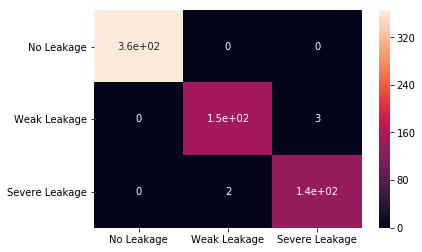

In [25]:
# KNN applied to training data and predict on test data with 1 neighbor

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(x_train, y_train)
pred = knn.predict(x_test)
print("Accuracy Score is: ")
print(knn.score(x_test, y_test))
print()
print("Classification Report: ")
print(classification_report(y_test, pred))
conf = confusion_matrix(y_test, pred)
conf
# Plot Confusion Matrix
label = ["No Leakage","Weak Leakage","Severe Leakage"]
sns.heatmap(conf, annot = True, xticklabels = label, yticklabels = label)
plt.show()



In [26]:
parameters = {
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample":[0.6,0.8],
    "n_estimators":[100, 500],
    }

clf = GridSearchCV(GradientBoostingClassifier(), 
                   parameters, cv=10, n_jobs=3)

clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.best_params_)

1.0
{'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.6}


Accuracy Score is: 
0.9923780487804879

Classification Report: 
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       365
          1       0.98      0.99      0.98       151
          2       0.99      0.98      0.98       140

avg / total       0.99      0.99      0.99       656



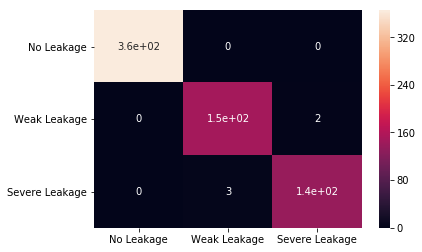

In [27]:
# Gradient Boosting Classification Algorithm applied to train data

GB = GradientBoostingClassifier(n_estimators = 500, 
                                learning_rate = 0.1, 
                                subsample = 0.6, 
                                random_state = 1)
GB.fit(x_train, y_train)
GB.score(x_train, y_train)
# Predict Random Forest Algorithm on Test Data
predictions_GB = GB.predict(x_test)

predictions_GB
# Print Accuracy Score for Random Forest Algorithm
print("Accuracy Score is: ")
print(accuracy_score(y_test, predictions_GB))
print()
# Classification Report of Prediction
print("Classification Report: ")
print(classification_report(y_test, predictions_GB))
# Confusion Matrix for predictions made
conf = confusion_matrix(y_test, predictions_GB)
conf
# Plot Confusion Matrix
label = ["No Leakage","Weak Leakage","Severe Leakage"]
sns.heatmap(conf, annot = True, xticklabels = label, yticklabels = label)
plt.show()

PS4     0.031177
PS6     0.312942
CP      0.316020
PS3     0.370377
CE      0.446765
PS5     0.480134
TS4     0.539514
TS3     0.594873
FS2     0.705970
VS1     0.824536
TS1     1.302641
EPS1    1.460270
TS2     1.639222
PS2     1.826296
FS1     3.027143
PS1     3.405173
SE      9.583613
dtype: float64


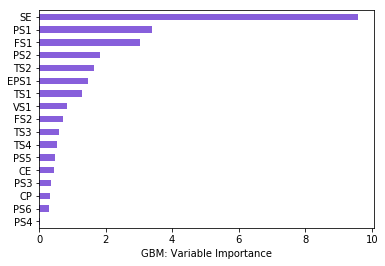

In [28]:
feature_importance = GB.feature_importances_*100
rel_imp = pd.Series(feature_importance, index = x.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='#875FDB', )
plt.xlabel('GBM: Variable Importance')
plt.gca().legend_ = None